In [12]:
from spyglass.common import Session
from hex_maze_behavior import HexMazeBlock, HexMazeChoice
import pandas as pd

# Join HexMazeChoice with a bunch of other tables
# We need the Session table for session_id and subject_id
# We need HexMazeBlock and Trial for opto_cond and session_type
df = pd.DataFrame((HexMazeChoice() * HexMazeBlock().join_with_trial() * Session()).fetch(as_dict=True))

# Binary dependent variable
df["choose_left"] = (df["choice_direction"] == "left").astype(int)

# Open question: in Tim's paper, random effects were estimated over the levels of rat and session-within-rat.
# For Berke Lab, we only have one session (epoch) per day. BUT for Frank lab, we have multiple epochs per session.
# Do we want to estimate random effects over the level of epoch_id instead of (or in addition to??), session_id?
df["epoch_id"] = df["session_id"].astype(str) + "_epoch" + df["epoch"].astype(str)

# Keep only columns useful for regression
regression_cols = [
    "subject_id",            # random effect
    "session_id",            # nested grouping/random effect
    "epoch_id",              # nested grouping/random effect
    "session_description",   # we may want to filter based on opto sessions (Frank Lab)
    "opto_cond",             # we may want to filter based on opto condition to see effects here
    "task_type",             # we may want to filter based on `probability change` vs `barrier change`
    "block",                 # we may want to filter based on block?
    "block_trial_num",       # we may want to filter based on trial (e.g. trials >25 to allow for learning)
    "choose_left",           # binary dependent variable
    "reward_prob_diff",      # predictor
    "path_length_diff",      # predictor
]
regression_df = df[regression_cols].copy()

# Convert all non-numeric columns to 'category' dtype
for col in regression_df.columns:
    if not pd.api.types.is_numeric_dtype(regression_df[col]):
        regression_df[col] = regression_df[col].astype('str')

display(regression_df)

,subject_id,session_id,epoch_id,session_description,opto_cond,task_type,block,block_trial_num,choose_left,reward_prob_diff,path_length_diff
0,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,no_delay,probability change,1,2,1,40.0,2.0
1,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,None,probability change,1,3,1,-80.0,-6.0
2,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,no_delay,probability change,1,4,0,-40.0,-4.0
3,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,delay,probability change,1,5,0,80.0,6.0
4,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,delay,probability change,1,6,1,40.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
7569,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,14,0,40.0,2.0
7570,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,15,1,80.0,0.0
7571,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,16,0,40.0,2.0
7572,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,17,1,80.0,0.0


In [24]:
from spyglass.common import Session

subset = regression_df[
    (regression_df["subject_id"] == "BraveLu") &
    (regression_df["session_description"] == "ThetaStimLatePhase")
]
subset

subset["session_id"].unique()

array(['BraveLu_20240617', 'BraveLu_20240622'], dtype=object)

In [7]:
df = pd.DataFrame((HexMazeChoice() * HexMazeBlock().join_with_trial() * Session()).fetch(as_dict=True))
# Keep only columns useful for regression
test_cols = [
    "block",                 # we may want to filter based on block?
    "block_trial_num",       # we may want to filter based on trial (e.g. trials >25 to allow for learning)
    "start_port",
    "end_port",
    "p_a",
    "p_b",
    "p_c",
    "choice_direction",           # binary dependent variable
    "reward_prob_diff",      # predictor
    "path_length_diff",      # predictor
]
test_df = df[test_cols].copy()
display(test_df[test_df['block_trial_num'] == 15])

,block,block_trial_num,start_port,end_port,p_a,p_b,p_c,choice_direction,reward_prob_diff,path_length_diff
13,1,15,C,A,10.0,50.0,90.0,right,-40.0,-6.0
82,2,15,B,A,90.0,10.0,50.0,left,40.0,-8.0
151,3,15,A,B,10.0,90.0,50.0,right,40.0,-2.0
219,1,15,A,B,90.0,50.0,10.0,right,40.0,0.0
288,2,15,B,C,50.0,10.0,90.0,right,40.0,-2.0
...,...,...,...,...,...,...,...,...,...,...
4899,1,15,A,C,50.0,10.0,90.0,left,80.0,4.0
4976,2,15,C,A,50.0,10.0,90.0,right,40.0,-6.0
5006,3,15,C,A,50.0,10.0,90.0,right,40.0,6.0
5054,4,15,B,C,50.0,10.0,90.0,right,40.0,-2.0


In [25]:
HexMazeChoice()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),block the block number within the epoch,block_trial_num trial number within the block,choice_direction 'left' or 'right',reward_prob_diff reward probability difference,path_length_diff path length difference
BraveLu20240516_.nwb,1,1,2,left,40.0,2.0
BraveLu20240516_.nwb,1,1,3,left,-80.0,-6.0
BraveLu20240516_.nwb,1,1,4,right,-40.0,-4.0
BraveLu20240516_.nwb,1,1,5,right,80.0,6.0
BraveLu20240516_.nwb,1,1,6,left,40.0,2.0
BraveLu20240516_.nwb,1,1,7,right,80.0,6.0
BraveLu20240516_.nwb,1,1,8,left,40.0,2.0
BraveLu20240516_.nwb,1,1,9,right,80.0,6.0
BraveLu20240516_.nwb,1,1,10,left,40.0,2.0
BraveLu20240516_.nwb,1,1,11,right,80.0,6.0


In [ ]:
# Try to do this in python!!
# I keep running into this error when doing model.fit() and it makes me sad:
# NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'pandas.core.frame.DataFrame'>'

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pymer4.models import glmer

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead
scaler = MinMaxScaler()
regression_df[['reward_prob_diff_scaled', 'path_length_diff_scaled']] = scaler.fit_transform(
    regression_df[['reward_prob_diff', 'path_length_diff']]
)

# Subset trials > 25 to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df['block_trial_num'] > 25]

# Mixed-effects regression (identical to Tim's glmer)
model = glmer(
    formula=(
        "choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled "
        "+ (reward_prob_diff_scaled + path_length_diff_scaled | subject_id) "
        "+ (reward_prob_diff_scaled + path_length_diff_scaled | session_id)"
    ),
    data=df_subset,
    family='binomial'
)
results = model.fit()

# Save outputs
results.coefs.to_csv("choose_left_regression_summary.csv")
model.ranef.to_csv("choose_left_regression_coefs_by_rat.csv")

In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Extra save name so we don't keep overwriting
name = "v1"

# Create output directory if it doesn't exist so R doesn't get mad
import os
os.makedirs("regression_output", exist_ok=True)

# Import required R packages
base = importr('base')
lme4 = importr('lme4')

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead
scaler = MinMaxScaler()
regression_df[['reward_prob_diff_scaled', 'path_length_diff_scaled']] = scaler.fit_transform(
    regression_df[['reward_prob_diff', 'path_length_diff']]
)

# Subset trials > 25 to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df['block_trial_num'] > 10].copy()
    
# Convert df to R - the keep conversion inside the context
with localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df_subset)

# Now assign outside the converter (r_df is already an R object)
r.assign('df_r', r_df)

# Do mixed-effects regression in R
r('''
model <- glmer(
    choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | subject_id) +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | session_id),
    data = df_r,
    family = binomial,
    control = glmerControl(optimizer = "bobyqa")
)
''')

# Print model summary
print(r('summary(model)'))

# Get fixed effects, random effects by rat, and random effects by session
r(f'''
# Extract fixed effects
# This is the population-level average effects across all rats/sessions

fixed_effects <- as.data.frame(summary(model)$coefficients)
fixed_effects$term <- rownames(fixed_effects)
write.csv(fixed_effects, "regression_output/fixed_effects_summary_{name}.csv", row.names = FALSE)

# Extract random effects by rat
# This is the complete coefficients for each rat (fixed effect + this rat's deviation)

ranef_by_subject <- as.data.frame(coef(model)$subject_id)
ranef_by_subject$subject_id <- rownames(ranef_by_subject)
write.csv(ranef_by_subject, "regression_output/effects_by_subject_{name}.csv", row.names = FALSE)

# Extract random effects by session
# This is the complete coefficients for each session (fixed effect + this session's deviation)

ranef_by_session <- as.data.frame(coef(model)$session_id)
ranef_by_session$session_id <- rownames(ranef_by_session)
write.csv(ranef_by_session, "regression_output/effects_by_session_{name}.csv", row.names = FALSE)
''')

# Read the csvs to get the results back into python
fixed_effects = pd.read_csv(f"regression_output/fixed_effects_summary_{name}.csv")
effects_by_subject = pd.read_csv(f"regression_output/effects_by_subject_{name}.csv")
effects_by_session = pd.read_csv(f"regression_output/effects_by_session_{name}.csv")

display(fixed_effects)
display(effects_by_subject)
display(effects_by_session)

R callback write-console: boundary (singular) fit: see help('isSingular')
  


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +  
    (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
        subject_id) + (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
    session_id)
   Data: df_r
Control: glmerControl(optimizer = "bobyqa")

      AIC       BIC    logLik -2*log(L)  df.resid 
   8580.5    8681.7   -4275.3    8550.5      6265 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9642 -0.9531 -0.6199  1.0130  2.6903 

Random effects:
 Groups     Name                    Variance Std.Dev. Corr       
 session_id (Intercept)             0.34704  0.5891              
            reward_prob_diff_scaled 0.56762  0.7534   -0.87      
            path_length_diff_scaled 0.63740  0.7984   -0.36 -0.14
 subject_id (Intercept)             0.17830  0.4223              
            reward_prob_diff_s

,Estimate,Std. Error,z value,Pr(>|z|),term
0,0.247240,0.278756,0.886942,0.375110,(Intercept)
1,-0.055967,0.259705,-0.215502,0.829376,reward_prob_diff_scaled
2,-0.853128,0.778848,-1.095372,0.273354,path_length_diff_scaled


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,subject_id
0,0.233175,-0.287877,-0.078710,BraveLu
1,0.551703,0.190967,-2.395346,IM-1478
2,0.021398,-0.165101,0.054752,IM-1594
3,0.183636,-0.037147,-0.755472,IM-1871
4,0.929538,0.407710,-4.023173,IM-1875
5,-0.188704,-0.358491,1.192302,IM-1890_otto
6,-0.024821,-0.159691,0.152075,Toby


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,session_id
0,0.734457,-0.487045,-1.320207,BraveLu_20240516
1,-0.515424,0.599108,-0.063066,BraveLu_20240518
2,0.015717,0.676571,-1.713473,BraveLu_20240519
3,0.423008,-0.442504,-0.549323,BraveLu_20240617
4,1.441852,-1.634168,-0.874225,BraveLu_20240622
5,0.407558,0.013570,-1.433717,Darling_20250720
6,0.340402,-0.373636,-0.459088,IM-1478_20220725
7,0.017309,0.548972,-1.464389,IM-1478_20220726
8,-0.270472,0.497600,-0.520938,IM-1594_20230726
9,0.286384,-0.415306,-0.243325,IM-1594_20230727


Same but epoch instead of session

In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Extra save name so we don't keep overwriting
name = "v2"

# Create output directory if it doesn't exist so R doesn't get mad
import os
os.makedirs("regression_output", exist_ok=True)

# Import required R packages
base = importr('base')
lme4 = importr('lme4')

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead
scaler = MinMaxScaler()
regression_df[['reward_prob_diff_scaled', 'path_length_diff_scaled']] = scaler.fit_transform(
    regression_df[['reward_prob_diff', 'path_length_diff']]
)

# Subset trials > 25 to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df['block_trial_num'] > 10].copy()
    
# Convert df to R - the keep conversion inside the context
with localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df_subset)

# Now assign outside the converter (r_df is already an R object)
r.assign('df_r', r_df)

# Do mixed-effects regression in R
r('''
model <- glmer(
    choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | subject_id) +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | epoch_id),
    data = df_r,
    family = binomial,
    control = glmerControl(optimizer = "bobyqa")
)
''')

# Print model summary
print(r('summary(model)'))

# Get fixed effects, random effects by rat, and random effects by epoch
r(f'''
# Extract fixed effects
# This is the population-level average effects across all rats/epochs

fixed_effects <- as.data.frame(summary(model)$coefficients)
fixed_effects$term <- rownames(fixed_effects)
write.csv(fixed_effects, "regression_output/fixed_effects_summary_{name}.csv", row.names = FALSE)

# Extract random effects by rat
# This is the complete coefficients for each rat (fixed effect + this rat's deviation)

ranef_by_subject <- as.data.frame(coef(model)$subject_id)
ranef_by_subject$subject_id <- rownames(ranef_by_subject)
write.csv(ranef_by_subject, "regression_output/effects_by_subject_{name}.csv", row.names = FALSE)

# Extract random effects by epoch
# This is the complete coefficients for each epoch (fixed effect + this epoch's deviation)

ranef_by_epoch <- as.data.frame(coef(model)$epoch_id)
ranef_by_epoch$epoch_id <- rownames(ranef_by_epoch)
write.csv(ranef_by_epoch, "regression_output/effects_by_epoch_{name}.csv", row.names = FALSE)
''')

# Read the csvs to get the results back into python
fixed_effects = pd.read_csv(f"regression_output/fixed_effects_summary_{name}.csv")
effects_by_subject = pd.read_csv(f"regression_output/effects_by_subject_{name}.csv")
effects_by_session = pd.read_csv(f"regression_output/effects_by_epoch_{name}.csv")

display(fixed_effects)
display(effects_by_subject)
display(effects_by_session)

R callback write-console: boundary (singular) fit: see help('isSingular')
  


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +  
    (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
        subject_id) + (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
    epoch_id)
   Data: df_r
Control: glmerControl(optimizer = "bobyqa")

      AIC       BIC    logLik -2*log(L)  df.resid 
   8159.8    8261.0   -4064.9    8129.8      6265 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-52.991  -0.861  -0.364   0.889   4.681 

Random effects:
 Groups     Name                    Variance Std.Dev. Corr       
 epoch_id   (Intercept)              9.8979  3.1461              
            reward_prob_diff_scaled 14.6527  3.8279   -0.93      
            path_length_diff_scaled  5.0255  2.2418   -0.07 -0.29
 subject_id (Intercept)              0.1819  0.4265              
            reward_prob_diff_sca

,Estimate,Std. Error,z value,Pr(>|z|),term
0,0.880097,0.726349,1.211671,0.225638,(Intercept)
1,-1.054952,0.827512,-1.274848,0.202363,reward_prob_diff_scaled
2,-0.409808,0.777838,-0.526856,0.598294,path_length_diff_scaled


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,subject_id
0,1.134578,-1.415849,-0.129818,BraveLu
1,0.908690,-0.722208,-1.402706,IM-1478
2,0.785846,-1.138957,0.083799,IM-1594
3,0.852144,-1.038229,-0.377674,IM-1871
4,0.998128,-0.573951,-2.059191,IM-1875
5,0.765374,-1.462814,1.029638,IM-1890_otto
6,0.706651,-1.054937,0.074301,Toby


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,epoch_id
0,0.281427,2.170648,-3.959892,BraveLu_20240516_epoch1
1,8.266096,-10.441626,0.891088,BraveLu_20240516_epoch3
2,1.991601,-1.714444,-1.518760,BraveLu_20240516_epoch5
3,-0.183439,1.109316,-2.095361,BraveLu_20240516_epoch7
4,-0.220380,0.516102,-0.762303,BraveLu_20240518_epoch1
5,-1.161397,0.717974,0.822749,BraveLu_20240518_epoch3
6,-0.549684,1.182453,-0.974395,BraveLu_20240518_epoch5
7,-0.986270,0.066300,1.811131,BraveLu_20240518_epoch7
8,0.223975,2.957709,-6.482113,BraveLu_20240519_epoch1
9,-4.874631,5.312583,0.392905,BraveLu_20240519_epoch3


Have claude make some plots (haven't evaluated them yet)

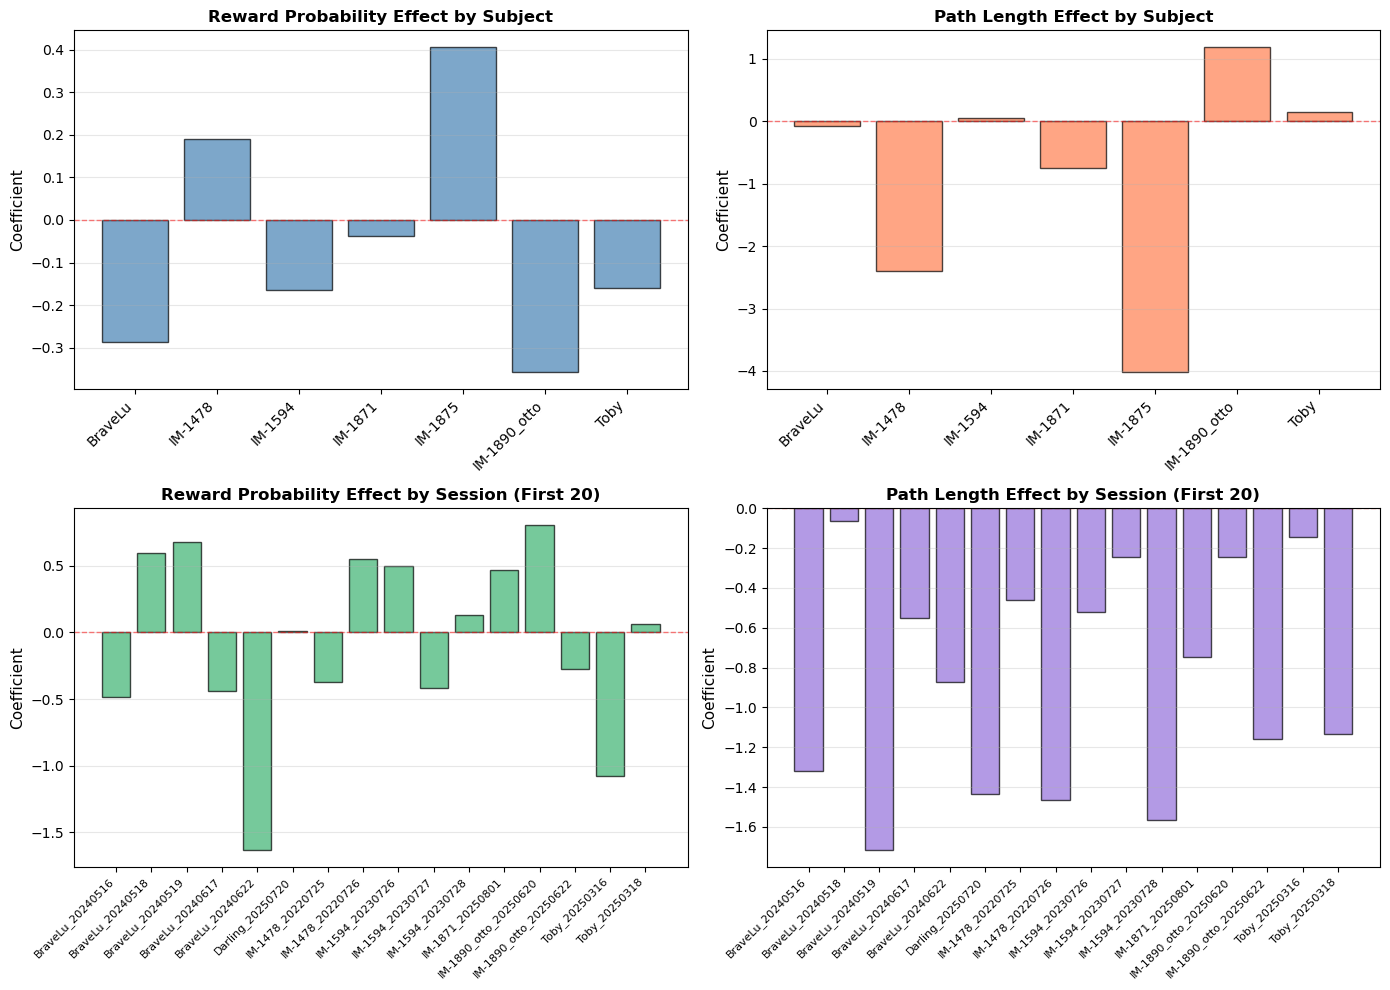

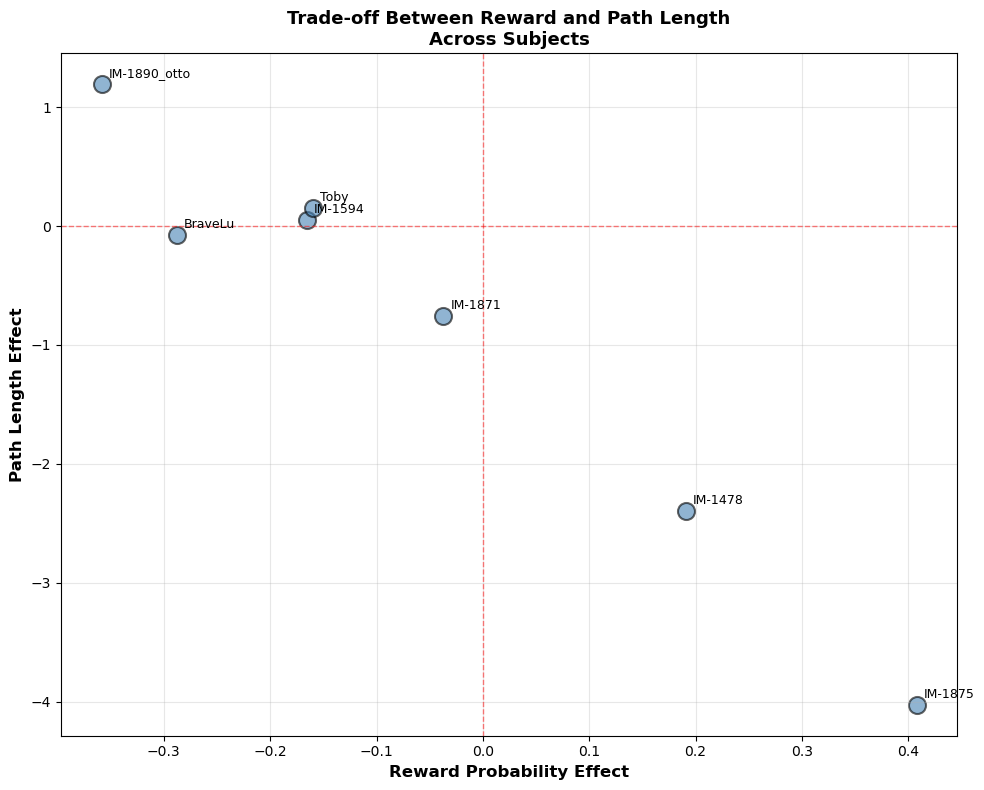

/tmp/ipykernel_1394211/1601899221.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Reward Probability', 'Path Length'],


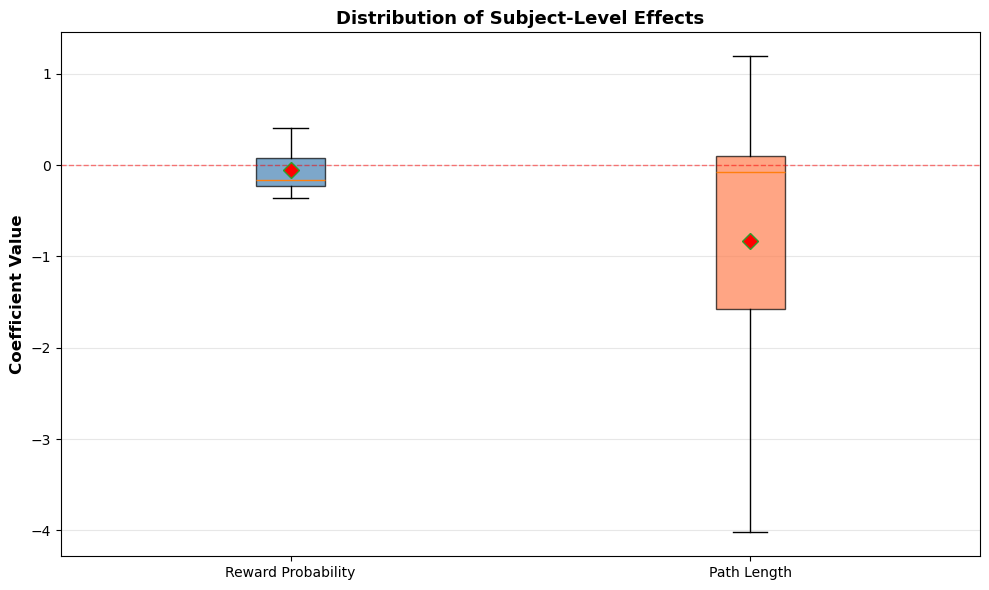


Plots saved:
1. subject_and_session_effects.png - Bar plots of effects by subject and session
2. reward_vs_pathlength_tradeoff.png - Scatter plot showing trade-offs
3. effect_distributions.png - Box plots of effect distributions


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Reward probability effects by subject
ax1 = axes[0, 0]
subjects = effects_by_subject['subject_id'].values
reward_effects = effects_by_subject['reward_prob_diff_scaled'].values
x_pos = np.arange(len(subjects))

ax1.bar(x_pos, reward_effects, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(subjects, rotation=45, ha='right')
ax1.set_ylabel('Coefficient', fontsize=11)
ax1.set_title('Reward Probability Effect by Subject', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Path length effects by subject
ax2 = axes[0, 1]
path_effects = effects_by_subject['path_length_diff_scaled'].values

ax2.bar(x_pos, path_effects, color='coral', alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(subjects, rotation=45, ha='right')
ax2.set_ylabel('Coefficient', fontsize=11)
ax2.set_title('Path Length Effect by Subject', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Reward probability effects by session
ax3 = axes[1, 0]
sessions = effects_by_session['session_id'].values[:20]  # Show first 20 sessions
reward_effects_session = effects_by_session['reward_prob_diff_scaled'].values[:20]
x_pos_session = np.arange(len(sessions))

ax3.bar(x_pos_session, reward_effects_session, color='mediumseagreen', alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xticks(x_pos_session)
ax3.set_xticklabels(sessions, rotation=45, ha='right', fontsize=8)
ax3.set_ylabel('Coefficient', fontsize=11)
ax3.set_title('Reward Probability Effect by Session (First 20)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Path length effects by session
ax4 = axes[1, 1]
path_effects_session = effects_by_session['path_length_diff_scaled'].values[:20]

ax4.bar(x_pos_session, path_effects_session, color='mediumpurple', alpha=0.7, edgecolor='black')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xticks(x_pos_session)
ax4.set_xticklabels(sessions, rotation=45, ha='right', fontsize=8)
ax4.set_ylabel('Coefficient', fontsize=11)
ax4.set_title('Path Length Effect by Session (First 20)', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('subject_and_session_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Scatter of reward vs path length effects by subject
fig2, ax = plt.subplots(figsize=(10, 8))

ax.scatter(effects_by_subject['reward_prob_diff_scaled'], 
           effects_by_subject['path_length_diff_scaled'],
           s=150, alpha=0.6, c='steelblue', edgecolors='black', linewidth=1.5)

# Add subject labels
for idx, subject in enumerate(effects_by_subject['subject_id']):
    ax.annotate(subject, 
                (effects_by_subject['reward_prob_diff_scaled'].iloc[idx],
                 effects_by_subject['path_length_diff_scaled'].iloc[idx]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add reference lines at 0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Reward Probability Effect', fontsize=12, fontweight='bold')
ax.set_ylabel('Path Length Effect', fontsize=12, fontweight='bold')
ax.set_title('Trade-off Between Reward and Path Length\nAcross Subjects', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reward_vs_pathlength_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics plot
fig3, ax = plt.subplots(figsize=(10, 6))

# Prepare data for box plots
data_to_plot = [
    effects_by_subject['reward_prob_diff_scaled'].values,
    effects_by_subject['path_length_diff_scaled'].values
]

bp = ax.boxplot(data_to_plot, labels=['Reward Probability', 'Path Length'],
                patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Color the boxes
colors = ['steelblue', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Subject-Level Effects', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('effect_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlots saved:")
print("1. subject_and_session_effects.png - Bar plots of effects by subject and session")
print("2. reward_vs_pathlength_tradeoff.png - Scatter plot showing trade-offs")
print("3. effect_distributions.png - Box plots of effect distributions")

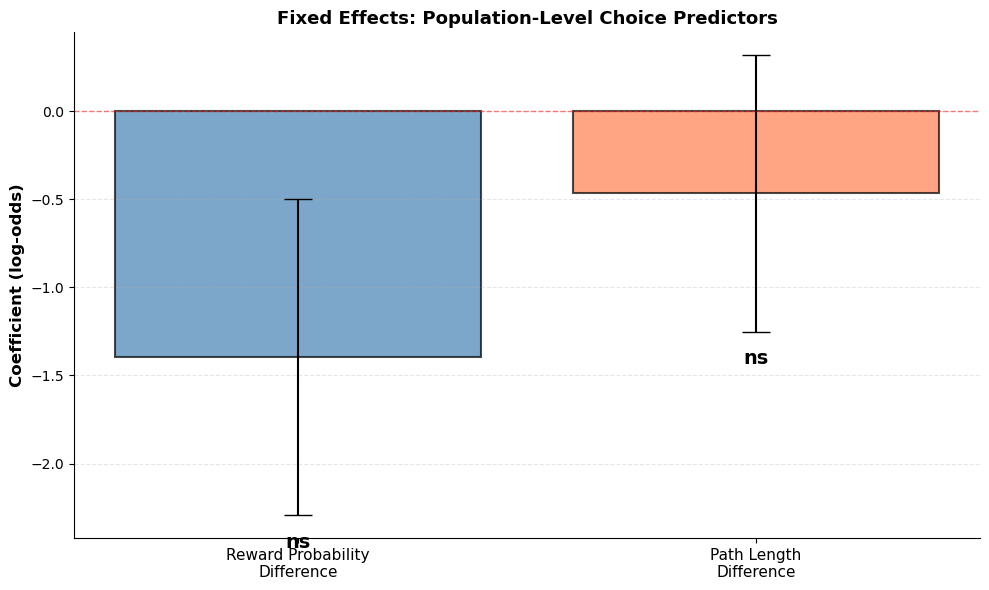

/tmp/ipykernel_1394211/755775325.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,


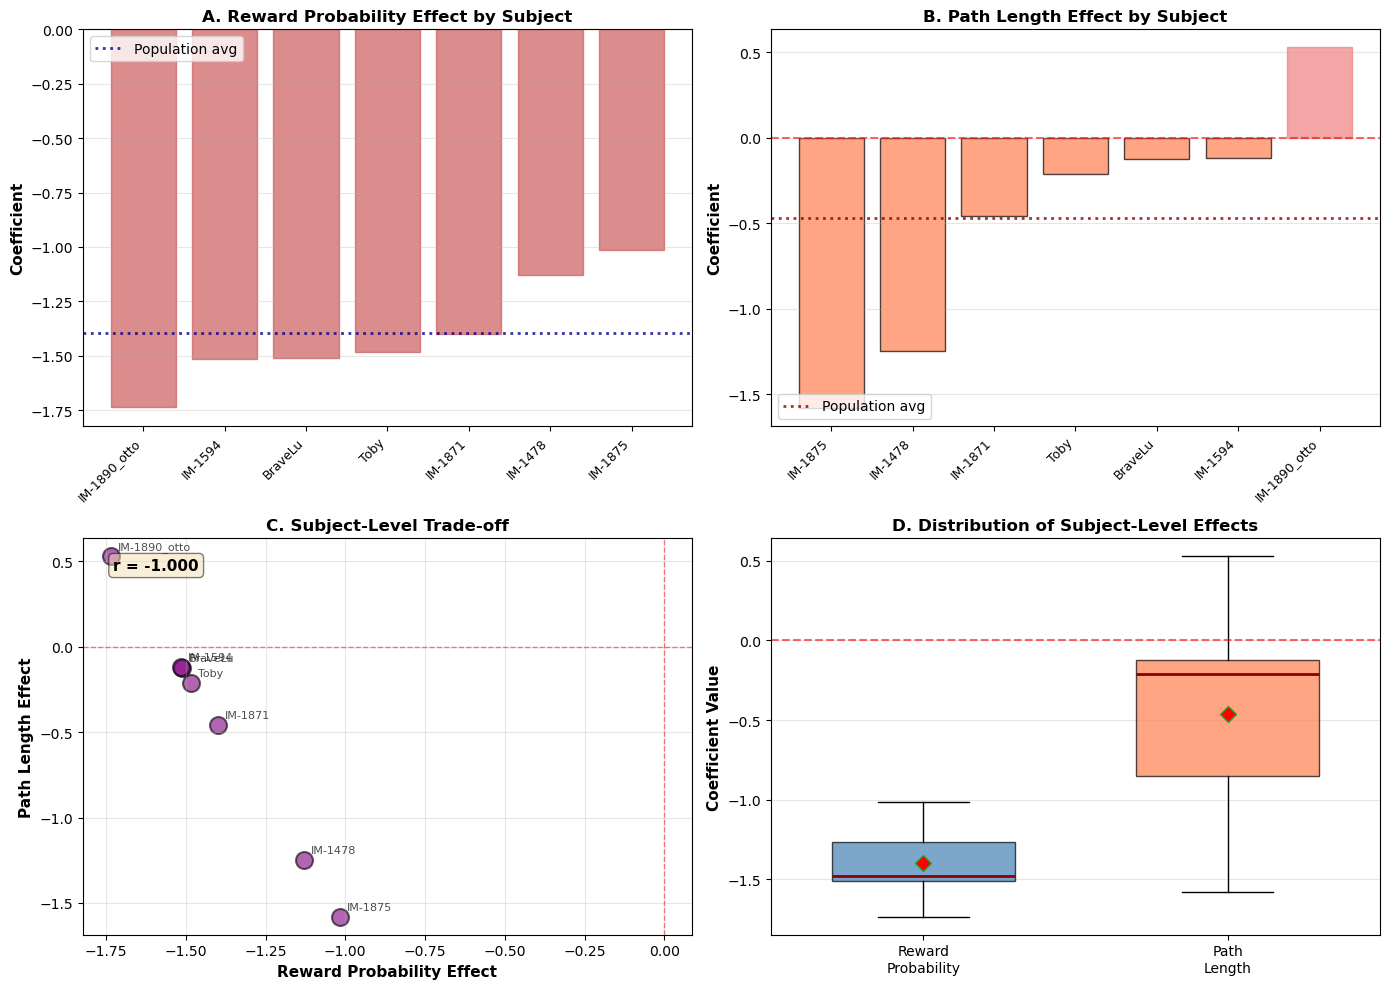

KeyError: 'session_id'

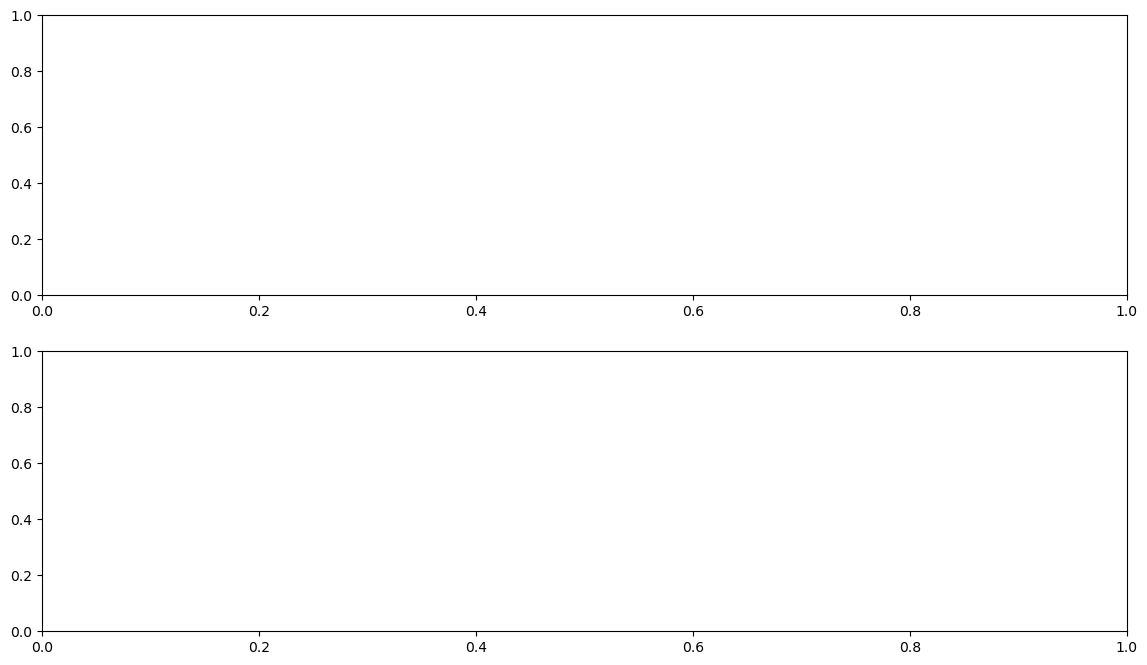

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for better-looking plots
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12

# ============================================================================
# FIGURE 1: Fixed Effects with Error Bars
# ============================================================================
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Extract fixed effects (skip intercept for clearer visualization)
fixed_predictors = fixed_effects[fixed_effects['term'] != '(Intercept)'].copy()
terms = fixed_predictors['term'].values
estimates = fixed_predictors['Estimate'].values
std_errors = fixed_predictors['Std. Error'].values

# Create bar plot with error bars
x_pos = np.arange(len(terms))
colors = ['steelblue', 'coral']
bars = ax1.bar(x_pos, estimates, yerr=std_errors, capsize=10, 
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add significance stars based on p-values
for i, (est, pval) in enumerate(zip(estimates, fixed_predictors['Pr(>|z|)'].values)):
    sig_level = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
    y_pos = est + std_errors[i] + 0.1 if est > 0 else est - std_errors[i] - 0.1
    ax1.text(i, y_pos, sig_level, ha='center', va='bottom' if est > 0 else 'top', 
             fontsize=14, fontweight='bold')

ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Reward Probability\nDifference', 'Path Length\nDifference'], fontsize=11)
ax1.set_ylabel('Coefficient (log-odds)', fontsize=12, fontweight='bold')
ax1.set_title('Fixed Effects: Population-Level Choice Predictors', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('regression_output/fig1_fixed_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 2: Subject-Level Effects (4 panels)
# ============================================================================
fig2, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sort subjects by reward effect for better visualization
effects_by_subject_sorted = effects_by_subject.sort_values('reward_prob_diff_scaled')

subjects = effects_by_subject_sorted['subject_id'].values
x_pos = np.arange(len(subjects))

# Panel A: Reward probability effects by subject
ax = axes[0, 0]
reward_effects = effects_by_subject_sorted['reward_prob_diff_scaled'].values
bars = ax.bar(x_pos, reward_effects, color='steelblue', alpha=0.7, edgecolor='black')
# Color bars based on effect size
for i, bar in enumerate(bars):
    if reward_effects[i] < 0:
        bar.set_color('indianred')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
ax.axhline(y=fixed_effects[fixed_effects['term'] == 'reward_prob_diff_scaled']['Estimate'].values[0], 
           color='darkblue', linestyle=':', linewidth=2, alpha=0.8, label='Population avg')
ax.set_xticks(x_pos)
ax.set_xticklabels(subjects, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Coefficient', fontsize=11, fontweight='bold')
ax.set_title('A. Reward Probability Effect by Subject', fontsize=12, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Panel B: Path length effects by subject
ax = axes[0, 1]
effects_by_subject_sorted2 = effects_by_subject.sort_values('path_length_diff_scaled')
subjects2 = effects_by_subject_sorted2['subject_id'].values
path_effects = effects_by_subject_sorted2['path_length_diff_scaled'].values
x_pos2 = np.arange(len(subjects2))

bars = ax.bar(x_pos2, path_effects, color='coral', alpha=0.7, edgecolor='black')
# Color bars based on effect size
for i, bar in enumerate(bars):
    if path_effects[i] > 0:
        bar.set_color('lightcoral')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
ax.axhline(y=fixed_effects[fixed_effects['term'] == 'path_length_diff_scaled']['Estimate'].values[0], 
           color='darkred', linestyle=':', linewidth=2, alpha=0.8, label='Population avg')
ax.set_xticks(x_pos2)
ax.set_xticklabels(subjects2, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Coefficient', fontsize=11, fontweight='bold')
ax.set_title('B. Path Length Effect by Subject', fontsize=12, fontweight='bold')
ax.legend(loc='lower left')
ax.grid(axis='y', alpha=0.3)

# Panel C: Scatter plot - reward vs path length tradeoff
ax = axes[1, 0]
scatter = ax.scatter(effects_by_subject['reward_prob_diff_scaled'], 
                     effects_by_subject['path_length_diff_scaled'],
                     s=150, alpha=0.6, c='purple', edgecolors='black', linewidth=1.5)

# Add subject labels
for idx, subject in enumerate(effects_by_subject['subject_id']):
    ax.annotate(subject, 
                (effects_by_subject['reward_prob_diff_scaled'].iloc[idx],
                 effects_by_subject['path_length_diff_scaled'].iloc[idx]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

# Add correlation
corr = np.corrcoef(effects_by_subject['reward_prob_diff_scaled'], 
                   effects_by_subject['path_length_diff_scaled'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
        fontsize=11, fontweight='bold', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add reference lines
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Reward Probability Effect', fontsize=11, fontweight='bold')
ax.set_ylabel('Path Length Effect', fontsize=11, fontweight='bold')
ax.set_title('C. Subject-Level Trade-off', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Panel D: Distribution comparison (violin plot alternative using histograms)
ax = axes[1, 1]
data_to_plot = [effects_by_subject['reward_prob_diff_scaled'].values,
                effects_by_subject['path_length_diff_scaled'].values]
bp = ax.boxplot(data_to_plot, 
                labels=['Reward\nProbability', 'Path\nLength'],
                patch_artist=True, 
                showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                medianprops=dict(color='darkred', linewidth=2),
                widths=0.6)

colors = ['steelblue', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
ax.set_ylabel('Coefficient Value', fontsize=11, fontweight='bold')
ax.set_title('D. Distribution of Subject-Level Effects', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('regression_output/fig2_subject_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 3: Session-Level Effects (first 30 sessions)
# ============================================================================
fig3, axes = plt.subplots(2, 1, figsize=(14, 8))

n_sessions = min(30, len(effects_by_session))
sessions = effects_by_session['session_id'].values[:n_sessions]
x_pos = np.arange(n_sessions)

# Panel A: Reward effects by session
ax = axes[0]
reward_effects_session = effects_by_session['reward_prob_diff_scaled'].values[:n_sessions]
bars = ax.bar(x_pos, reward_effects_session, color='mediumseagreen', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
ax.axhline(y=fixed_effects[fixed_effects['term'] == 'reward_prob_diff_scaled']['Estimate'].values[0], 
           color='darkgreen', linestyle=':', linewidth=2, alpha=0.8, label='Population avg')
ax.set_xticks(x_pos)
ax.set_xticklabels(sessions, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Coefficient', fontsize=11, fontweight='bold')
ax.set_title(f'Reward Probability Effect by Session (First {n_sessions})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Panel B: Path length effects by session
ax = axes[1]
path_effects_session = effects_by_session['path_length_diff_scaled'].values[:n_sessions]
bars = ax.bar(x_pos, path_effects_session, color='mediumpurple', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
ax.axhline(y=fixed_effects[fixed_effects['term'] == 'path_length_diff_scaled']['Estimate'].values[0], 
           color='indigo', linestyle=':', linewidth=2, alpha=0.8, label='Population avg')
ax.set_xticks(x_pos)
ax.set_xticklabels(sessions, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Coefficient', fontsize=11, fontweight='bold')
ax.set_title(f'Path Length Effect by Session (First {n_sessions})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('regression_output/fig3_session_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 4: Summary Statistics Table as Image
# ============================================================================
fig4, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Create summary statistics
summary_data = []
summary_data.append(['Metric', 'Reward Probability', 'Path Length'])
summary_data.append(['', '', ''])
summary_data.append(['Fixed Effect (population)', 
                     f"{fixed_effects[fixed_effects['term'] == 'reward_prob_diff_scaled']['Estimate'].values[0]:.3f}",
                     f"{fixed_effects[fixed_effects['term'] == 'path_length_diff_scaled']['Estimate'].values[0]:.3f}"])
summary_data.append(['SE', 
                     f"{fixed_effects[fixed_effects['term'] == 'reward_prob_diff_scaled']['Std. Error'].values[0]:.3f}",
                     f"{fixed_effects[fixed_effects['term'] == 'path_length_diff_scaled']['Std. Error'].values[0]:.3f}"])
summary_data.append(['p-value', 
                     f"{fixed_effects[fixed_effects['term'] == 'reward_prob_diff_scaled']['Pr(>|z|)'].values[0]:.4f}",
                     f"{fixed_effects[fixed_effects['term'] == 'path_length_diff_scaled']['Pr(>|z|)'].values[0]:.4f}"])
summary_data.append(['', '', ''])
summary_data.append(['Subject-level variation', '', ''])
summary_data.append(['Mean', 
                     f"{effects_by_subject['reward_prob_diff_scaled'].mean():.3f}",
                     f"{effects_by_subject['path_length_diff_scaled'].mean():.3f}"])
summary_data.append(['SD', 
                     f"{effects_by_subject['reward_prob_diff_scaled'].std():.3f}",
                     f"{effects_by_subject['path_length_diff_scaled'].std():.3f}"])
summary_data.append(['Min', 
                     f"{effects_by_subject['reward_prob_diff_scaled'].min():.3f}",
                     f"{effects_by_subject['path_length_diff_scaled'].min():.3f}"])
summary_data.append(['Max', 
                     f"{effects_by_subject['reward_prob_diff_scaled'].max():.3f}",
                     f"{effects_by_subject['path_length_diff_scaled'].max():.3f}"])

table = ax.table(cellText=summary_data, cellLoc='center', loc='center',
                 colWidths=[0.3, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header row
for i in range(3):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style section headers
for row in [1, 6]:
    for col in range(3):
        table[(row, col)].set_facecolor('#E7E6E6')

plt.title('Summary Statistics: Mixed-Effects Logistic Regression', 
          fontsize=14, fontweight='bold', pad=20)
plt.savefig('regression_output/fig4_summary_table.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("All figures saved to regression_output/")
print("="*80)
print("Files created:")
print("  - fig1_fixed_effects.png")
print("  - fig2_subject_effects.png")
print("  - fig3_session_effects.png")
print("  - fig4_summary_table.png")